# Argument Quality Prediction

El objetivo de este proyecto se basa en crear modelos de machine para clasificar los elementos argumentativos en los textos escritos por estudiantes como "efectivos", "adecuados" o "ineficaces". Esta clasificación automatizada tiene como objetivo proporcionar una mejor retroalimentación a los estudiantes, para así ellos puedan mejorar sus habilidades de escritura.


In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight
import joblib

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Load the dataset
train_df = pd.read_csv('data/train_preprocessed.csv')

# Display the first few rows
print("First 5 rows of the dataset:")
print(train_df.head())

# Check for null values
print("\nNull values before dropping:")
print(train_df.isnull().sum())

# Drop rows with null values
train_df = train_df.dropna()

print("\nNull values after dropping:")
print(train_df.isnull().sum())

# Define a custom tokenizer
def custom_tokenizer(text):
    # Lowercase the text
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', punctuation))
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

# Apply the tokenizer to the text data
train_df['tokens'] = train_df['text'].apply(custom_tokenizer)

# Display tokenized text
print("\nTokenized text samples:")
print(train_df[['text', 'tokens']].head())

# Encode the labels
le = LabelEncoder()
y = le.fit_transform(train_df['discourse_effectiveness'])

# Split the data into training and validation sets **before** applying any resampling
X_train, X_val, y_train, y_val = train_test_split(
    train_df['tokens'], y, test_size=0.2, random_state=42, stratify=y
)

print(f'\nTraining samples: {len(X_train)}')
print(f'Validation samples: {len(X_val)}')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chama\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chama\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


First 5 rows of the dataset:
   discourse_id      essay_id  \
0  0013cc385424  007ACE74B050   
1  9704a709b505  007ACE74B050   
2  c22adee811b6  007ACE74B050   
3  a10d361e54e4  007ACE74B050   
4  db3e453ec4e2  007ACE74B050   

                                      discourse_text discourse_type  \
0  Hi, i'm Isaac, i'm going to be writing about h...           Lead   
1  On my perspective, I think that the face is a ...       Position   
2  I think that the face is a natural landform be...          Claim   
3  If life was on Mars, we would know by now. The...       Evidence   
4  People thought that the face was formed by ali...   Counterclaim   

  discourse_effectiveness  text_length  \
0                Adequate          317   
1                Adequate          210   
2                Adequate          105   
3                Adequate          362   
4                Adequate          101   

                                                text  
0  hi im isaac im going writing face 

## 2. Building Vocabulary and Encoding Sequences

In [5]:
from collections import defaultdict

# Build vocabulary based on training data
def build_vocab(tokenized_texts, min_freq=2):
    freq = defaultdict(int)
    for tokens in tokenized_texts:
        for token in tokens:
            freq[token] += 1
    vocab = {'<PAD>':0, '<UNK>':1}
    for token, count in freq.items():
        if count >= min_freq:
            vocab[token] = len(vocab)
    return vocab

vocab = build_vocab(X_train, min_freq=2)
print(f'Vocabulary size: {len(vocab)}')

# Function to encode tokens to indices
def encode_tokens(tokenized_texts, vocab):
    return [
        [vocab.get(token, vocab['<UNK>']) for token in tokens]
        for tokens in tokenized_texts
    ]

# Encode training and validation data
X_train_encoded = encode_tokens(X_train, vocab)
X_val_encoded = encode_tokens(X_val, vocab)

# Determine maximum sequence length
max_len = max([len(seq) for seq in X_train_encoded])
print(f'Maximum sequence length: {max_len}')

# To prevent extremely long sequences, set a maximum length (e.g., 100)
max_len = 100

# Function to pad sequences
def pad_sequences(sequences, max_len):
    padded = []
    for seq in sequences:
        if len(seq) < max_len:
            padded.append(seq + [vocab['<PAD>']] * (max_len - len(seq)))
        else:
            padded.append(seq[:max_len])
    return np.array(padded)

X_train_padded = pad_sequences(X_train_encoded, max_len)
X_val_padded = pad_sequences(X_val_encoded, max_len)

print(f'Padded training data shape: {X_train_padded.shape}')
print(f'Padded validation data shape: {X_val_padded.shape}')


Vocabulary size: 11944
Maximum sequence length: 371
Padded training data shape: (29405, 100)
Padded validation data shape: (7352, 100)


## 3. Handling Class Imbalance

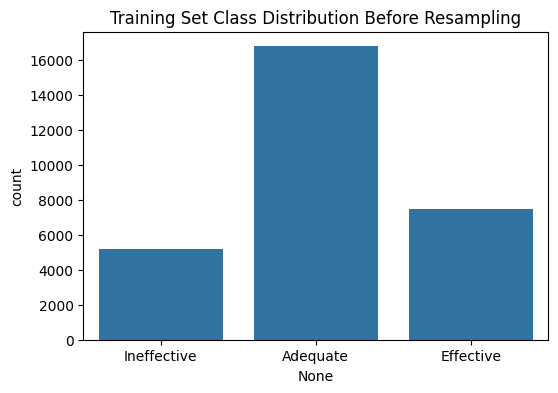


Class weights: tensor([0.5842, 1.3137, 1.8973])


['class_weights.joblib']

In [6]:
# %%
# Visualize class distribution before resampling
plt.figure(figsize=(6,4))
sns.countplot(x=pd.Series(y_train).map(lambda x: le.inverse_transform([x])[0]))
plt.title('Training Set Class Distribution Before Resampling')
plt.show()

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train),
                                     y=y_train)

class_weights = torch.tensor(class_weights, dtype=torch.float)
print(f'\nClass weights: {class_weights}')

# Save class weights for future use
joblib.dump(class_weights.numpy(), 'class_weights.joblib')


## 4. Creating PyTorch Dataset and DataLoader

In [7]:
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return self.X.size(0)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create Dataset objects
train_dataset = TextDataset(X_train_padded, y_train)
val_dataset = TextDataset(X_val_padded, y_val)

# Create DataLoader objects
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f'\nNumber of batches in training loader: {len(train_loader)}')
print(f'Number of batches in validation loader: {len(val_loader)}')



Number of batches in training loader: 230
Number of batches in validation loader: 58


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 5. Define the LSTM Model

In [10]:
# %%
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, n_layers, dropout, pad_idx):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=n_layers,
                            bidirectional=True, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)  # [batch_size, seq_len, embed_dim]
        lstm_out, (hidden, cell) = self.lstm(embedded)  # lstm_out: [batch_size, seq_len, hidden_dim*2]
        # Concatenate the final forward and backward hidden states
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)  # [batch_size, hidden_dim*2]
        out = self.dropout(hidden)
        out = self.fc(out)
        return out


LSTMClassifier(
  (embedding): Embedding(11944, 100, padding_idx=0)
  (lstm): LSTM(100, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)


## 6. Initialize the Model, Loss Function, and Optimizer

In [ ]:
# Define model parameters
vocab_size = len(vocab)
embed_dim = 100
hidden_dim = 128
output_dim = len(le.classes_)
n_layers = 2
dropout = 0.5
pad_idx = vocab['<PAD>']

model = LSTMClassifier(vocab_size, embed_dim, hidden_dim, output_dim, n_layers, dropout, pad_idx)
model = model.to(device)

print(model)

# Define loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                 factor=0.5, patience=3,
                                                 verbose=True)

## 7. Training the LSTM Model

In [11]:
# Define training parameters
epochs = 20
patience = 5
best_val_loss = np.inf
patience_counter = 0

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_epoch_loss = val_running_loss / val_total
    val_epoch_acc = val_correct / val_total
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)

    print(f'Epoch {epoch+1}/{epochs}')
    print(f'Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f}')
    print(f'Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_acc:.4f}')

    # Step the scheduler
    scheduler.step(val_epoch_loss)

    # Check for early stopping
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        patience_counter = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_lstm_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print('Early stopping triggered!')
            break


Epoch 1/20
Train Loss: 1.0060 | Train Acc: 0.4072
Val Loss: 0.9672 | Val Acc: 0.3998
Epoch 2/20
Train Loss: 0.9248 | Train Acc: 0.4972
Val Loss: 0.9198 | Val Acc: 0.4971
Epoch 3/20
Train Loss: 0.8677 | Train Acc: 0.5281
Val Loss: 0.8968 | Val Acc: 0.5254
Epoch 4/20
Train Loss: 0.8191 | Train Acc: 0.5544
Val Loss: 0.8898 | Val Acc: 0.5381
Epoch 5/20
Train Loss: 0.7745 | Train Acc: 0.5824
Val Loss: 0.8877 | Val Acc: 0.4969
Epoch 6/20
Train Loss: 0.7304 | Train Acc: 0.5993
Val Loss: 0.9149 | Val Acc: 0.5328
Epoch 7/20
Train Loss: 0.6958 | Train Acc: 0.6300
Val Loss: 0.9644 | Val Acc: 0.5280
Epoch 8/20
Train Loss: 0.6461 | Train Acc: 0.6575
Val Loss: 0.9831 | Val Acc: 0.5422
Epoch 9/20
Train Loss: 0.6027 | Train Acc: 0.6857
Val Loss: 1.0231 | Val Acc: 0.5237
Epoch 10/20
Train Loss: 0.5227 | Train Acc: 0.7363
Val Loss: 1.1818 | Val Acc: 0.5433
Early stopping triggered!


## 8. Load the Best Model

In [12]:
# Load the best model weights
model.load_state_dict(torch.load('best_lstm_model.pth'))

<All keys matched successfully>

## 9. Evaluation

In [13]:
def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    return np.array(all_preds), np.array(all_labels)

# Get predictions on the validation set
y_pred, y_true = evaluate_model(model, val_loader)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'\nValidation Accuracy: {accuracy:.4f}')
print(f'Validation Weighted F1-Score: {f1:.4f}')

# Print classification report
print('\nClassification Report:')
print(classification_report(y_true, y_pred, target_names=le.classes_))


Validation Accuracy: 0.4969
Validation Weighted F1-Score: 0.4963

Classification Report:
              precision    recall  f1-score   support

    Adequate       0.69      0.36      0.48      4195
   Effective       0.51      0.72      0.60      1865
 Ineffective       0.31      0.61      0.41      1292

    accuracy                           0.50      7352
   macro avg       0.51      0.56      0.50      7352
weighted avg       0.58      0.50      0.50      7352



## 10. Confusion Matrix

In [ ]:
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.show()

# Plot the confusion matrix
plot_confusion(y_true, y_pred, 'Confusion Matrix - Optimized LSTM Model')

## 11. Training Curves

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()

plt.show()